# Week 9: Fourier Transforms

## Library Imports go here

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
import csv
from scipy.sparse import eye
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Basic Code for Observables Analysis

<font color = blue>

Begin by copy-pasting the essential code for Crank-Nicholson into this notebook (starting with the generic sparse array code, then the Hamiltonian code, then the T-matrix code, and then the time evolver)

In [337]:
def M(A, B, C, matrix_size, x_inf):
    """
    Function that efficiently generates our matrix M using sparse matrix techniques

    A : function A(x)
    B : function B(x)
    C : function C(x)
    matrix_size : the size of the matrix M
    x_inf : numerical infinity

    returns : matrix M as an array
    """
    rows = np.array([i + 1 for i in range(matrix_size - 2) for j in range(3)])
    rows = np.append([0, 0], rows)
    rows = np.append(rows, [matrix_size - 1, matrix_size - 1])

    n = matrix_size * 3 - 6  # Length of the array
    cols = np.repeat(np.arange(n//3 + 2), 3)[:n] + np.tile([0,1,2], n//3 + 1)[:n]
    cols = np.append([0, 1], cols)
    cols = np.append(cols, [matrix_size - 2, matrix_size - 1])

    del_x = (2 * x_inf) / (matrix_size + 1)
    x_j = -x_inf
    
    data = np.zeros(len(cols), dtype=complex)
    k = 0
    for i in range(matrix_size):
        if i == 0:
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
            data[k] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            k += 1
        elif i == matrix_size - 1:
            data[k] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
            k += 1
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
        else:
            data[k] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
            k += 1
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
            data[k] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            k += 1
        x_j += del_x
    return sparse.coo_matrix((data, (rows, cols)), shape=(matrix_size, matrix_size))

In [339]:
def H(V, x_inf, matrix_size):
    """
    Function that creates a sparse hamiltonian matrix

    V : potential function
    x_inf : numerical infinity
    matrix_size : size of our matrix (N by N)

    returns : the hamiltonian matrix
    """
    def A(x):
        return -1/2
    def B(x):
        return 0
    def C(x):
        return V(x)
    return M(A, B, C, matrix_size, x_inf)

In [341]:
def T_matrix(V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates our matrix T as defined above

    V : poential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : matrix T as defined above
    """
    Hamiltonian = H(V, x_inf, matrix_size)
    I = eye(matrix_size, format = "csr")
    del_t = final_time / time_count
    T1 = (I - (1j * del_t * Hamiltonian / 2))
    T2 = linalg.inv(I + (1j * del_t * Hamiltonian / 2))
    return T1.dot(T2)

In [343]:
def time_evolution(psi_initial, V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates the time evolution of psi

    psi_initial : psi function at t = 0
    V : poential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : list of lists with each item of the outer list corresponding to components
    of the wavefunction at time 0 - M and inner list components corresponding to components
    0 - N
    """
    del_x = (2 * x_inf) / (matrix_size + 1)
    x_j = -x_inf
    first_component = np.zeros(matrix_size, dtype=complex) # first component of Psi (first time val)
    for i in range(matrix_size):
        first_component[i] = psi_initial(-x_inf + (del_x * (i + 1)))
    Psi = np.zeros((time_count, matrix_size), dtype=complex)
    Psi[0] = first_component
    T = T_matrix(V, x_inf, matrix_size, final_time, time_count)
    for i in range(time_count - 1):
        Psi[i + 1] = T.dot(Psi[i])
    return Psi

### The Normalization

<font color = blue>
    
We know the normalization integral of the wavefunction

$$
\int_{-\infty}^{\infty} |\Psi(x, t)|^2 \, dx
$$

is going to be approximated as

$$
\Delta_x \, \Big(\vec{\Psi}^{n *}\cdot \vec{\Psi}^{n}\Big)
$$

at time $t_n$.  Write a function that takes the same inputs as your time evolver, and then uses this function to generates the normalization integral at each time $t_n$,  It should output two lists: the times $[t_n]$ and the $[\Delta_x \, \Big(\vec{\Psi}^{n *}\cdot \vec{\Psi}^{n}\Big)]$ values.

In [347]:
def normalization(psi_initial, V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates the normalization integral at each time tn

    psi_initial : psi function at t = 0
    V : potential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : list of times as well as list of del_x * |psi|^2
    """
    del_x = (2 * x_inf) / (matrix_size + 1)
    time_list = np.linspace(0, final_time, time_count)
    norm_vals = np.zeros(len(time_list), dtype=complex)
    psi = time_evolution(psi_initial, V, x_inf, matrix_size, final_time, time_count)
    for i in range(len(norm_vals)):
        norm_val = (np.dot(np.conj(psi[i]), psi[i])) * del_x
        norm_vals[i] = norm_val.real
    return time_list, norm_vals

### Finite Difference Matrices for Position and Momentum

#### The Momentum Matrix

<font color = blue>
Use the generic matrix making code to create a function which takes as inputs the spatial grid parameters, and outputs the momentum coo-type matrix.

In [352]:
def mom_matrix(x_inf, matrix_size):
    """
    function that generates the momentum matrix

    x_inf : numerical infinity
    matrix_size : the size of matrix N by N

    returns : momentum coo-type matrix
    """
    def A(x):
        return 0
    def B(x):
        return -1j
    def C(x):
        return 0
    return M(A, B, C, matrix_size, x_inf)

#### The Position Matrix

<font color = blue>
    
Then, do the same to create a position coo-type matrix.

In [356]:
def pos_matrix(x_inf, matrix_size):
    """
    function that generates the position matrix

    x_inf : numerical infinity
    matrix_size : the size of matrix N by N

    returns : position coo-type matrix
    """
    def A(x):
        return 0
    def B(x):
        return 0
    def C(x):
        return x
    return M(A, B, C, matrix_size, x_inf)

### Expectation Values and Uncertainties

<font color = blue>

Next, we want to write short functions that will compute for us the integrals we are interested in associated with expectation values and uncertainties. 

#### The Expectation Value of Position

<font color = blue>

Write a function (similar to the normalization function and with the same input structure) which computes the expectation value of position at each time, and returns both the list of times and the list of expectation values.

In [362]:
def expectation_pos(psi_initial, V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates the expectation value of position at each time tn

    psi_initial : psi function at t = 0
    V : potential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : list of times as well as list of expectation values at times tn
    """
    del_x = (2 * x_inf) / (matrix_size + 1)
    time_list = np.linspace(0, final_time, time_count)
    expectations_vals = np.zeros(len(time_list))
    psi = time_evolution(psi_initial, V, x_inf, matrix_size, final_time, time_count)
    
    pos = pos_matrix(x_inf, matrix_size)
    
    for i in range(len(expectations_vals)):
        expectations_val = np.dot(np.conj(psi[i]), (pos @ psi[i])) * del_x
        expectations_vals[i] = expectations_val.real
    return time_list, expectations_vals

#### The Expectation Value of Momentum

<font color = blue>
Repeat the process for the expectation value of momentum

In [366]:
def expectation_mom(psi_initial, V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates the expectation value of momentum at each time tn

    psi_initial : psi function at t = 0
    V : potential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : list of times as well as list of expectation values at times tn
    """
    del_x = (2 * x_inf) / (matrix_size + 1)
    time_list = np.linspace(0, final_time, time_count)
    expectations_vals = np.zeros(len(time_list))
    psi = time_evolution(psi_initial, V, x_inf, matrix_size, final_time, time_count)
    
    mom = mom_matrix(x_inf, matrix_size)
    
    for i in range(len(expectations_vals)):
        expectations_val = np.dot(np.conj(psi[i]), (mom @ psi[i])) * del_x
        expectations_vals[i] = expectations_val.real
    return time_list, expectations_vals

#### The Uncertainty in Position

<font color = blue>
Repeat the process once again for the uncertainty in position

In [534]:
def uncert_pos(psi_initial, V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates the uncertainty value of position at each time tn

    psi_initial : psi function at t = 0
    V : potential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : list of times as well as list of uncertainty values at times tn
    """
    del_x = (2 * x_inf) / (matrix_size + 1)
    time_list = np.linspace(0, final_time, time_count)
    uncertainty_vals = np.zeros(len(time_list))
    psi = time_evolution(psi_initial, V, x_inf, matrix_size, final_time, time_count)
    
    time, exp_pos = expectation_pos(psi_initial, V, x_inf, matrix_size, final_time, time_count)
    pos_squared = np.array([exp_pos[i]**2 for i in range(len(exp_pos))])
    pos = pos_matrix(x_inf, matrix_size)
    left_term = np.zeros(len(time_list))
    
    for i in range(len(uncertainty_vals)):
        left_term[i]= np.dot(np.conj(psi[i]), ((pos @ pos) @ psi[i])) * del_x

    uncertainty_vals = np.sqrt(left_term - pos_squared).real
    return time_list, uncertainty_vals

#### The Uncertainty in Momentum

<font color = blue>
And finally, repeat the process one more time for the uncertainty in momentum

In [546]:
def uncert_mom(psi_initial, V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates the uncertainty value of momentum at each time tn

    psi_initial : psi function at t = 0
    V : potential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : list of times as well as list of uncertainty values at times tn
    """
    del_x = (2 * x_inf) / (matrix_size + 1)
    time_list = np.linspace(0, final_time, time_count)
    uncertainty_vals = np.zeros(len(time_list))
    psi = time_evolution(psi_initial, V, x_inf, matrix_size, final_time, time_count)
    
    time, exp_mom = expectation_mom(psi_initial, V, x_inf, matrix_size, final_time, time_count)
    mom_squared = np.array([exp_mom[i]**2 for i in range(len(exp_mom))])
    mom = mom_matrix(x_inf, matrix_size)
    left_term = np.zeros(len(time_list))
    
    for i in range(len(uncertainty_vals)):
        left_term[i] = np.dot(np.conj(psi[i]), ((mom @ mom) @ psi[i])) * del_x
        
    uncertainty_vals = np.sqrt(left_term - mom_squared).real
    return time_list, uncertainty_vals

## Observables in Free Space*

<font color = blue>
Now we want to use our code to analyze the evolution of observables in free space, where $V(x) = 0$.  We will use the same two different initial wavefunction shapes as before:

$$
\psi_A(x) = \frac{1}{\pi^{1/4}\sqrt{\sigma}} \, e^{ip_0x} \, e^{-\frac{(x - x_0)^2}{2\sigma^2}}
$$

and

$$
\psi_B(x) = \left\{\begin{array}{rcl} 0 & \mbox{for} & x < x_0 - \sigma \\ \\ \sqrt{\frac{3}{2\sigma^3}} \, (x - x_0 + \sigma) e^{ip_0x} & \mbox{for} & x_0 - \sigma \le x < x_0 \\ \\ -\sqrt{\frac{3}{2\sigma^3}} \, (x - x_0 - \sigma) e^{ip_0x} & \mbox{for} & x_0 \le x < x_0 + \sigma \\ \\ 0 & \mbox{for} & x_0 \le x \end{array}\right.
$$

Both of these wavefunctions are correctly normalized, and are determined by three paramters $\{x_0, p_0, \sigma\}$: the first controls the initial value of $\langle x \rangle$, the second controls the initial value of $\langle p \rangle$, and the third controls the initial uncertainty in both position and momentum.

Below, you will want to recover the four different cases you explored in your previous assignment by making animations of wavefunction evolution -- here you will examine the observable evolution for the same four cases.

### Normalization

<font color = blue>
    
For each of the four cases you made animations of, use your "normalization" function to plot the normalization as a function of time.  Confirm that in each case the wavefunction remains properly normalized at all times.  (Note: it may be helpful to learn how to display multiple plots in a grid)

In [585]:
def V(x):
    """
    Zero potential function
    """
    return 0

def psiA1(x, x_o = 1, p_o = 1, sigma = 2):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

def psiB1(x, x_o = 1, p_o = 1, sigma = 2):
    if x < x_o - sigma or x >= x_o + sigma:
        return 0
    elif x - sigma <= x and x < x_o:
        return np.sqrt(2 / 2 * sigma**3) * (x - x_o + sigma) * np.exp(1j * p_o * x)
    else:
        return -np.sqrt(2 / 2 * sigma**3) * (x - x_o - sigma) * np.exp(1j * p_o * x)

def psiA2(x, x_o = -1, p_o = -1, sigma = .5):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

def psiB2(x, x_o = -1, p_o = -1, sigma = .5):
    if x < x_o - sigma or x >= x_o + sigma:
        return 0
    elif x - sigma <= x and x < x_o:
        return np.sqrt(2 / 2 * sigma**3) * (x - x_o + sigma) * np.exp(1j * p_o * x)
    else:
        return -np.sqrt(2 / 2 * sigma**3) * (x - x_o - sigma) * np.exp(1j * p_o * x)

Text(0, 0.5, 'normalization')

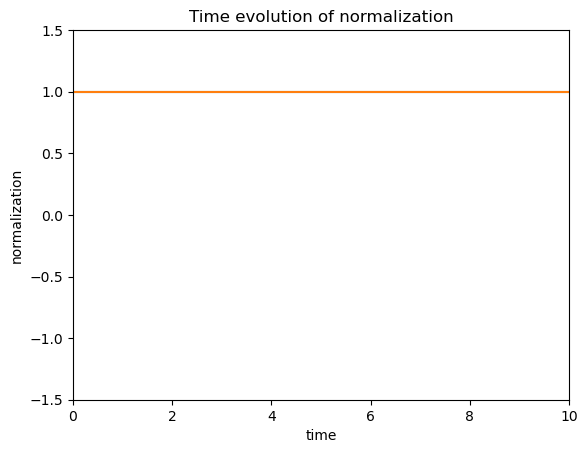

In [382]:
times1, norms1 = normalization(psiA1, V, 40, 1000, 10, 100)
times2, norms2 = normalization(psiA2, V, 40, 1000, 10, 100)
times3, norms3 = normalization(psiB1, V, 40, 1000, 10, 100)
times4, norms4 = normalization(psiB2, V, 40, 1000, 10, 100)

plt.plot(times1, norms1)
plt.plot(times2, norms2)
plt.plot(times3, norms3)


plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)
plt.title("Time evolution of normalization")
plt.xlabel("time")
plt.ylabel("normalization")

As we can see normalization stays very close to 1 throughout the time evolution of the data.

### * Expectation Values for Position and Momentum

<font color = blue>
Now we want to analyze the expectation values $\langle x \rangle$ and $\langle p \rangle$.  Remember that these should satisfy the relationships

$$
\frac{d\langle x \rangle}{dt} = \langle p \rangle, \hspace{.75in} \frac{d\langle p \rangle}{dt} = \left\langle - \frac{dV}{dx}\right\rangle = 0
$$

(they behave roughly like classical position and momentum for a particle with no forces acting on it.)  Create plots of $\langle x \rangle$ and $\langle p \rangle$ as functions of time, again for the four cases you analyzed earlier, and **discuss** what you see.

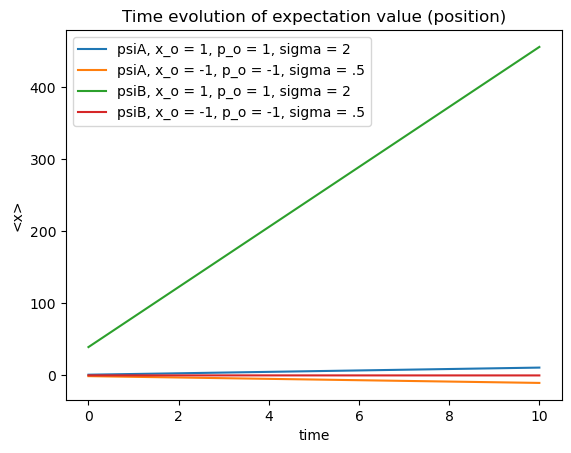

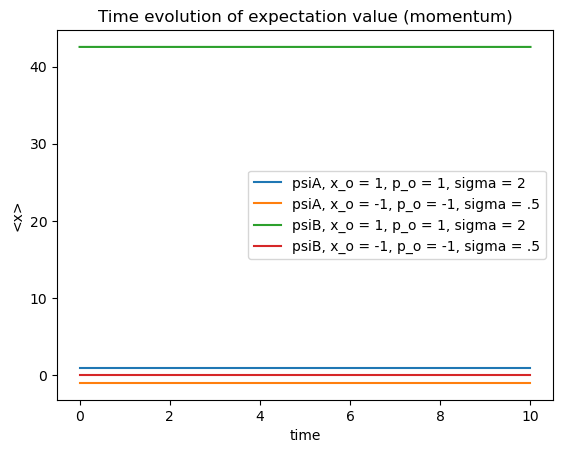

In [587]:
times1, expectations_pos1 = expectation_pos(psiA1, V, 40, 1000, 10, 100)
times2, expectations_pos2 = expectation_pos(psiA2, V, 40, 1000, 10, 100)
times3, expectations_pos3 = expectation_pos(psiB1, V, 40, 1000, 10, 100)
times4, expectations_pos4 = expectation_pos(psiB2, V, 40, 1000, 10, 100)

times1, expectations_mom1 = expectation_mom(psiA1, V, 40, 1000, 10, 100)
times2, expectations_mom2 = expectation_mom(psiA2, V, 40, 1000, 10, 100)
times3, expectations_mom3 = expectation_mom(psiB1, V, 40, 1000, 10, 100)
times4, expectations_mom4 = expectation_mom(psiB2, V, 40, 1000, 10, 100)

plt.plot(times1, expectations_pos1, label = "psiA, x_o = 1, p_o = 1, sigma = 2")
plt.plot(times2, expectations_pos2, label = "psiA, x_o = -1, p_o = -1, sigma = .5")
plt.plot(times3, expectations_pos3, label = "psiB, x_o = 1, p_o = 1, sigma = 2")
plt.plot(times4, expectations_pos4, label = "psiB, x_o = -1, p_o = -1, sigma = .5")
plt.title("Time evolution of expectation value (position)")
plt.xlabel("time")
plt.ylabel("<x>")
plt.legend()
plt.show()

plt.plot(times1, expectations_mom1, label = "psiA, x_o = 1, p_o = 1, sigma = 2")
plt.plot(times2, expectations_mom2, label = "psiA, x_o = -1, p_o = -1, sigma = .5")
plt.plot(times3, expectations_mom3, label = "psiB, x_o = 1, p_o = 1, sigma = 2")
plt.plot(times4, expectations_mom4, label = "psiB, x_o = -1, p_o = -1, sigma = .5")
plt.title("Time evolution of expectation value (momentum)")
plt.xlabel("time")
plt.ylabel("<p>")
plt.legend()
plt.show()

In these figures, firstly we can confirm that the slope of the expectation value in position = 0 as expected. Next we can also confirm that the slope of the position expecation value = the value of the momentum expectation value. Lastly, we can confirm that the particle is expected to move in the negative x direction when p = negative and vice versa.

### *Uncertainties in Position and Momentum

<font color = blue>
    
Now repeat the above exercise (including **discussion**) for the uncertainties in position and momentum.  Recall we know two important things about how these quantities should behave: first, momentum is conserved in this system while position isn't, which means $\Delta p$ should be constant, but not $\Delta x$.  Second, the uncertainty principle

$$
\Delta x \, \Delta p \ge \frac{1}{2}
$$

should be satisfied at all times.

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_98064/3840550927.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  left_term[i]= np.dot(np.conj(psi[i]), ((pos @ pos) @ psi[i])) * del_x
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_98064/3840550927.py:27: RuntimeWarning: invalid value encountered in sqrt
  uncertainty_vals = np.sqrt(left_term - pos_squared).real


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


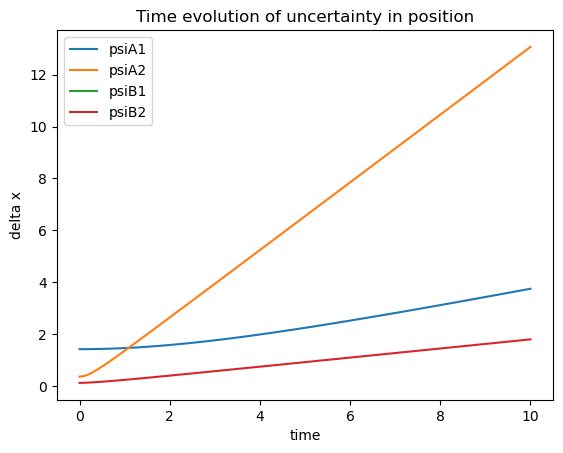

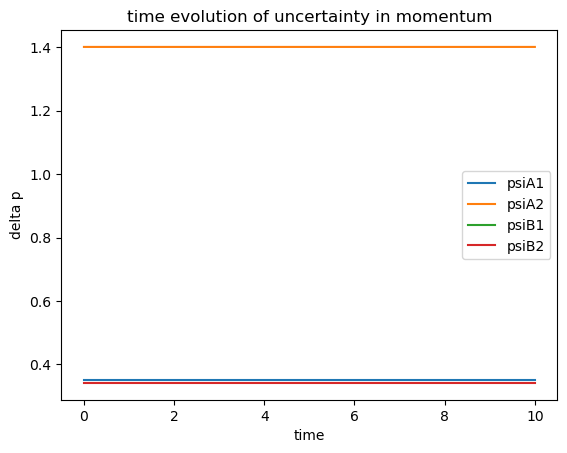

In [556]:
times1, uncertainty_pos1 = uncert_pos(psiA1, V, 40, 1000, 10, 100)
times2, uncertainty_pos2 = uncert_pos(psiA2, V, 40, 1000, 10, 100)
times3, uncertainty_pos3 = uncert_pos(psiB1, V, 40, 1000, 10, 50)
times4, uncertainty_pos4 = uncert_pos(psiB2, V, 40, 1000, 10, 50)

times1, uncertainty_mom1 = uncert_mom(psiA1, V, 40, 1000, 10, 100)
times2, uncertainty_mom2 = uncert_mom(psiA2, V, 40, 1000, 10, 100)
times3, uncertainty_mom3 = uncert_mom(psiB1, V, 40, 1000, 10, 50)
times4, uncertainty_mom4 = uncert_mom(psiB2, V, 40, 1000, 10, 50)

plt.plot(times1, uncertainty_pos1, label = "psiA1")
plt.plot(times2, uncertainty_pos2, label = "psiA2")
plt.plot(times3, uncertainty_pos3, label = "psiB1")
plt.plot(times4, uncertainty_pos4, label = "psiB2")
plt.title("Time evolution of uncertainty in position")
plt.xlabel("time")
plt.ylabel("delta x")
plt.legend()
plt.show()

plt.plot(times1, uncertainty_mom1, label = "psiA1")
plt.plot(times2, uncertainty_mom2, label = "psiA2")
plt.plot(times3, uncertainty_mom3, label = "psiB1")
plt.plot(times4, uncertainty_mom4, label = "psiB2")
plt.title("time evolution of uncertainty in momentum")
plt.xlabel("time")
plt.ylabel("delta p")
plt.legend()
plt.show()

In these figure, firstly we can confirm that the two psiA functions have uncertainties that adhere to the uncertainty principle. Its important to note that the psiB functions do not, however this is due to the "walls" that we are using (+-x_inf) that cause the wavefunction to exhibit weird properties. Changing these values we can see that there is a change in the data however unfortunately I could not find the goldilocks conditions. Lastly we can confirm that the uncertainty in momentum is constant and that as time goes on, the uncertainty in position increases in all four cases.

## * Observables in the SHO Potential

<font color = blue>
Another classic potential to explore is the SHO potential, which we can non-dimensionalize to be

$$
V(x) = \frac{1}{2}x^2
$$

We want to repeat the analysis we just performed for "free space" using this potential.  This time, we will use just the initial Gaussian wavefunction,

$$
\psi_A(x) = \frac{1}{\pi^{1/4}\sqrt{\sigma}} \, e^{ip_0x} \, e^{-\frac{(x - x_0)^2}{2\sigma^2}}
$$

and we will focus on the three cases

$$
x_0 = 0, \ p_0 = 0, \ \sigma = 1
$$

$$
x_0 = 1, \ p_0 = 0, \ \sigma = 1
$$

$$
x_0 = 0, \ p_0 = 1, \ \sigma = 1
$$

In each of these cases you will find the grid parameter choices

$$
x_{\infty} = 10, \ N = 1000, \ T = 20, \ M = 200
$$

to be appropriate.

It will also be helpful for you to know that the first of these cases actually corresponds to an *energy eigenstate* of the quantum SHO system.

In [590]:
def V(x):
    """
    Potential function for SHO
    """
    return (1/2) * x**2 

def psiA1(x, x_o = 0, p_o = 0, sigma = 1):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

def psiA2(x, x_o = 1, p_o = 0, sigma = 1):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

def psiA3(x, x_o = 0, p_o = 1, sigma = 1):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

### Normalization

<font color = blue>
    
For each of the three cases, use your "normalization" function to plot the normalization as a function of time.  Confirm that in each case the wavefunction remains properly normalized at all times.

Text(0, 0.5, 'normalization')

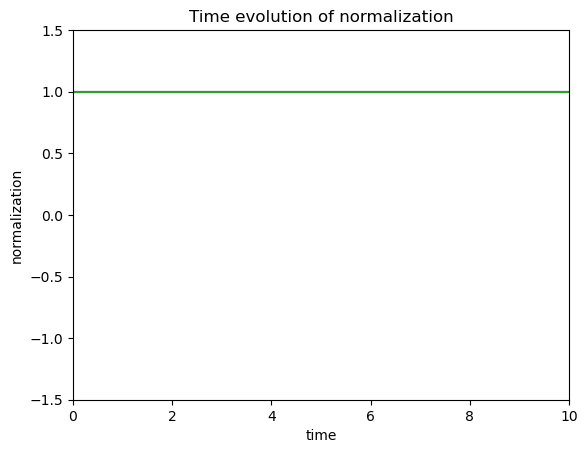

In [592]:
times1, norms1 = normalization(psiA1, V, 40, 1000, 10, 100)
times2, norms2 = normalization(psiA2, V, 40, 1000, 10, 100)
times3, norms3 = normalization(psiA3, V, 40, 1000, 10, 100)

plt.plot(times1, norms1)
plt.plot(times2, norms2)
plt.plot(times3, norms3)


plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)
plt.title("Time evolution of normalization")
plt.xlabel("time")
plt.ylabel("normalization")

We can confirm here that the normalization is 1 throughout the time evolution

### * Expectation Values for Position and Momentum

<font color = blue>
Now we want to analyze the expectation values $\langle x \rangle$ and $\langle p \rangle$.  Remember that these should satisfy the relationships

$$
\frac{d\langle x \rangle}{dt} = \langle p \rangle, \hspace{.75in} \frac{d\langle p \rangle}{dt} = \left\langle - \frac{dV}{dx}\right\rangle = 0
$$

(they behave roughly like classical position and momentum for a particle with no forces acting on it.)  Create plots of $\langle x \rangle$ and $\langle p \rangle$ as functions of time, again for the four cases you analyzed earlier, and **discuss** the results.

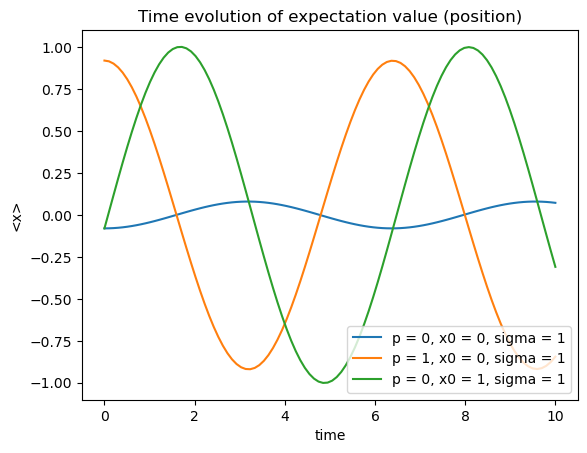

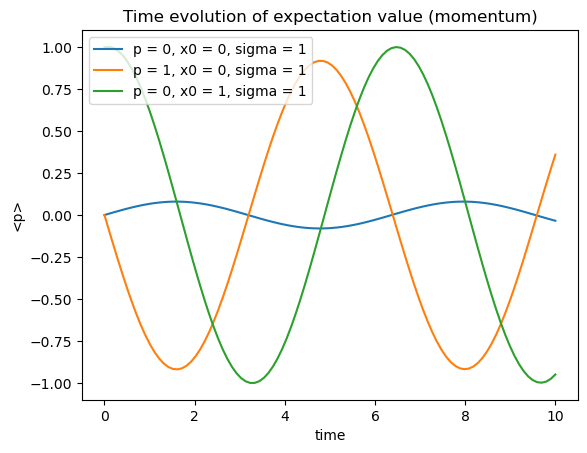

In [594]:
times1, expectations_pos1 = expectation_pos(psiA1, V, 40, 1000, 10, 100)
times2, expectations_pos2 = expectation_pos(psiA2, V, 40, 1000, 10, 100)
times3, expectations_pos3 = expectation_pos(psiA3, V, 40, 1000, 10, 100)

times1, expectations_mom1 = expectation_mom(psiA1, V, 40, 1000, 10, 100)
times2, expectations_mom2 = expectation_mom(psiA2, V, 40, 1000, 10, 100)
times3, expectations_mom3 = expectation_mom(psiA3, V, 40, 1000, 10, 100)

plt.plot(times1, expectations_pos1, label = "p = 0, x0 = 0, sigma = 1")
plt.plot(times2, expectations_pos2, label = "p = 1, x0 = 0, sigma = 1")
plt.plot(times3, expectations_pos3, label = "p = 0, x0 = 1, sigma = 1")
plt.title("Time evolution of expectation value (position)")
plt.xlabel("time")
plt.ylabel("<x>")
plt.legend()
plt.show()

plt.plot(times1, expectations_mom1, label = "p = 0, x0 = 0, sigma = 1")
plt.plot(times2, expectations_mom2, label = "p = 1, x0 = 0, sigma = 1")
plt.plot(times3, expectations_mom3, label = "p = 0, x0 = 1, sigma = 1")
plt.title("Time evolution of expectation value (momentum)")
plt.xlabel("time")
plt.ylabel("<p>")
plt.legend()
plt.show()

Here we can see some very interesting things especially compared to what we expect. Firstly, note that the momentum expectation value is changing. This is due to the fact that the wave is moving in one direction or the other (p). Next we can see that roughly speaking, the slope of the expectation value of position is equal to the momentum. Lastly we can see that the amplitude of the expectation value of momentum and position is based off of the initial momentum. (2p0)

### * Uncertainties in Position and Momentum

<font color = blue>
    
Now create graphs of $\Delta x$ and $\Delta p$ vs. t for each of the three cases.  This time, also create an explicit graph of $\Delta x \, \Delta p$ as a function of time for each case, so that you can check the uncertainty principle is satisfied.  **Discuss** the results.

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_98064/3840550927.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  left_term[i]= np.dot(np.conj(psi[i]), ((pos @ pos) @ psi[i])) * del_x


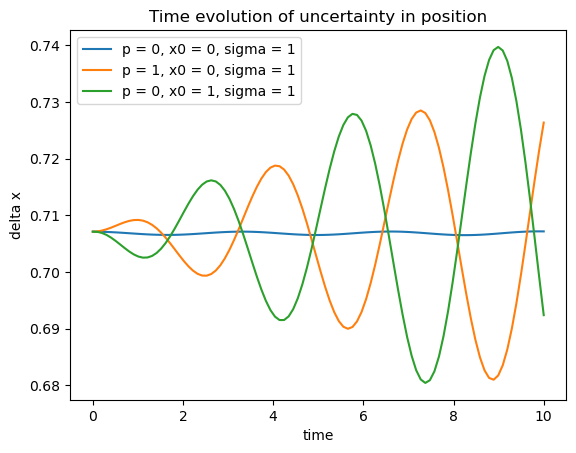

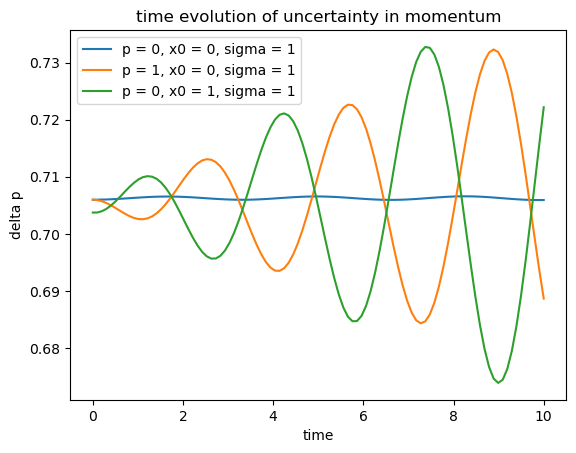

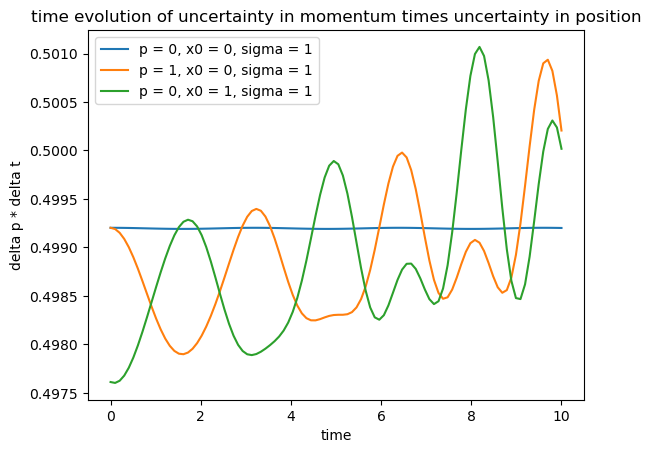

In [598]:
times1, uncertainty_pos1 = uncert_pos(psiA1, V, 40, 1000, 10, 100)
times2, uncertainty_pos2 = uncert_pos(psiA2, V, 40, 1000, 10, 100)
times3, uncertainty_pos3 = uncert_pos(psiA3, V, 40, 1000, 10, 100)

times1, uncertainty_mom1 = uncert_mom(psiA1, V, 40, 1000, 10, 100)
times2, uncertainty_mom2 = uncert_mom(psiA2, V, 40, 1000, 10, 100)
times3, uncertainty_mom3 = uncert_mom(psiA3, V, 40, 1000, 10, 100)


plt.plot(times1, uncertainty_pos1, label = "p = 0, x0 = 0, sigma = 1")
plt.plot(times2, uncertainty_pos2, label = "p = 1, x0 = 0, sigma = 1")
plt.plot(times3, uncertainty_pos3, label = "p = 0, x0 = 1, sigma = 1")
plt.title("Time evolution of uncertainty in position")
plt.xlabel("time")
plt.ylabel("delta x")
plt.legend()
plt.show()

plt.plot(times1, uncertainty_mom1, label = "p = 0, x0 = 0, sigma = 1")
plt.plot(times2, uncertainty_mom2, label = "p = 1, x0 = 0, sigma = 1")
plt.plot(times3, uncertainty_mom3, label = "p = 0, x0 = 1, sigma = 1")
plt.title("time evolution of uncertainty in momentum")
plt.xlabel("time")
plt.ylabel("delta p")
plt.legend()
plt.show()

del_x_del_p1 = np.zeros(len(uncertainty_pos1))
del_x_del_p2 = np.zeros(len(uncertainty_pos1))
del_x_del_p3 = np.zeros(len(uncertainty_pos1))

for i in range(len(del_x_del_p3)):
    del_x_del_p1[i] = uncertainty_pos1[i] * uncertainty_mom1[i]
    del_x_del_p2[i] = uncertainty_pos2[i] * uncertainty_mom2[i]
    del_x_del_p3[i] = uncertainty_pos3[i] * uncertainty_mom3[i]

plt.plot(times1, del_x_del_p1, label = "p = 0, x0 = 0, sigma = 1")
plt.plot(times2, del_x_del_p2, label = "p = 1, x0 = 0, sigma = 1")
plt.plot(times3, del_x_del_p3, label = "p = 0, x0 = 1, sigma = 1")
plt.title("time evolution of uncertainty in momentum times uncertainty in position")
plt.xlabel("time")
plt.ylabel("delta p * delta t")
plt.legend()
plt.show()

In these figures, we can see that firstly, within acceptable uncertainty the product of del_p and del_x is equal to 1/2 as expected. Next we can see that the slope of the uncertainty in del_p and del_x is proportional to the initial momentum. We can also see that roughly speaking, the slope of the uncertainty in position is equal to the momentum at any given time. Lastly, we can see that over time the amplitude of the uncertainty increases as we expect from a quantum wave evolving over time.

## A Basic Fourier Transform Function

### The Code

<font color = blue>
Construct a function that will implement the basic Fourier transform of a discrete data set:

$$
P_k = \sum_{j = 0}^{N-1} p_je^{2\pi ijk/N}, \hspace{.75in} k = 0, 1, 2, \dots, N-1
$$

Your function should take as input a list of discrete values $[p_0, p_1, \dots, p_{N-1}]$ and a time step $\Delta t$.  It should output both a list of frequencies $[f_k]$ and a list of transform values $[P_k]$, where the frequency is given by

$$
f_k = \left\{\begin{array}{rcl} k\Delta f = \frac{k}{N\Delta t} & \mbox{for} & k = 0, 1, 2, \dots, \frac{N}{2} \\ \\ -(N-k)\Delta f = \frac{k - N}{N\Delta t} & \mbox{for} & k = \frac{N}{2} + 1, \dots, N-1 \end{array}\right.
$$

This assumes $N$ is an even integer.  If the input list has an odd number of elements, have your code simply discard the last element of the input.

In [51]:
def basic_fourier(discrete_vals, del_t):
    """
    function that implements the basic fourier transform of a discrete data set

    discrete_vals : list of p vals of len N (note length of discrete vals is even)
    del_t : length of each time step on time grid

    return : list of frequecies and transform values
    """
    if len(discrete_vals) % 2 == 1:
        discrete_vals = np.delete(discrete_vals, len(discrete_vals) - 1)
    N = len(discrete_vals)
    P_k_vals = np.zeros(N, dtype=complex) 
    f_k_vals = np.zeros(N) 
    
    for k in range(N): #
        for j in range(N):
            P_k_vals[k] += discrete_vals[j] * np.exp(2 * np.pi * 1j * j * k / N)

            if k <= (N/2):
                f_k_vals[k] = k / (N * del_t)
            else:
                f_k_vals[k] = (k - N) / (N * del_t)
    return f_k_vals, P_k_vals
        

### A Simple Test

<font color = blue>
To test out your function, use

$$
p(t) = \cos 40\pi t
$$

.

Start by creating a list of discrete values from this function, working with the time interval $[0, 10]$, and the time step $\Delta t = 0.01$.  Input this into your Fourier function, and plot the results.  (Note that the output of the Fourier transform is complex -- you will have to "fix" this in order to plot things).

In a **discussion**, confirm that the peaks of the Fourier transform appear where they should, and have the heights that they should.

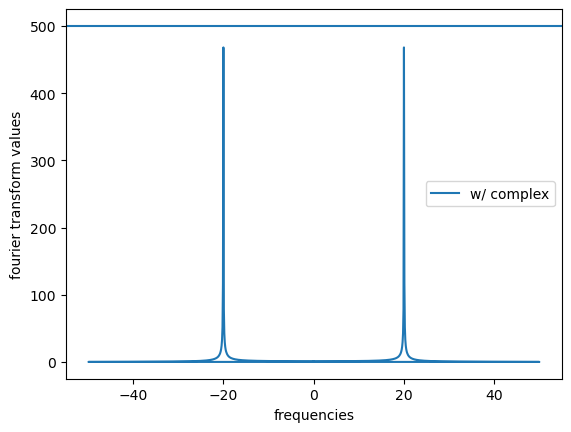

In [72]:
del_t = .01
final_t = 10
time_list = np.linspace(0, 10, int(final_t / del_t))

def p(t):
    """
    test function to create our discrete values
    """
    return np.cos(40 * np.pi * t)

discrete_vals = np.array([p(time) for time in time_list])
f_k, P_k = basic_fourier(discrete_vals, del_t)
k_vals = np.linspace(0, int(final_t / del_t) - 1, int(final_t / del_t))

plt.plot(f_k, np.abs(P_k), label = "w/ complex")
plt.xlabel("frequencies")
plt.ylabel("fourier transform values")
plt.axhline(500)
plt.legend()

In terms of the peaks of the delta functions, the should be close to or equal to $\frac{AN}{2}$ where A is the amplitude of the Pk function (= 1). Therefore since N = 1000, the peak should be $\approx 500$ which we can see in the graph. next,we must figure out why the peaks occur around $\pm 20$. We know that the peaks should occur when $k = -\overline{k}$ and $k = N - \overline{k}$, and we know that $\overline{f} = \overline{k}\Delta f = f_{\overline{k}}$. We can find these values for $\overline{f} = 20$

### Timing

<font color = blue>

Construct a function that takes as input the value $N$ and outputs the time required to find the Fourier transform of the function $p(t) = \cos 40\pi t$ on the interval $[0, 10]$, with $\Delta t = \frac{T}{N}$.  Use this function to create lists of the form $[N]$ and $[T_N]$, for $N = 50, 100, 150, 200, \dots, 1000$, and plot the results.

In a **discussion** identify what the time-scaling behavior you see in the plot is, and explain its algorirhmic origin.

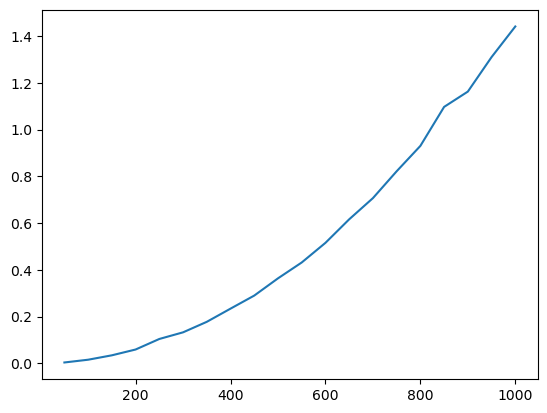

In [91]:
def timing(N):
    """
    function that outputs the time required to find the fourier transform of our test function with del_t = T / N
    """
    final_t = 10
    del_t = final_t / N
    time_list = np.linspace(0, final_t, int(N))

    def p(t):
        """
        test function to create our discrete values
        """
        return np.cos(40 * np.pi * t)

    discrete_vals = np.array([p(time) for time in time_list])
    start = time.time()
    f_k, P_k = basic_fourier(discrete_vals, del_t)
    end = time.time()
    return end - start

N_vals = np.linspace(50, 1000, 20)
T_N = np.array([])
for N in N_vals:
    T_N = np.append(T_N, timing(N))

plt.plot(N_vals, T_N)
plt.xlabel("Number of values in initial discrete list")
plt.ylabel("time taken to complete fourier transform")

In this graph i can see that the time taken scales with O(N^2). i can see this in the code (and algorithm), because we iterate over N two times in the function. other than this the only other time dependancy comes when iitialize (and updating) the arrays, which is neglidgeable compared to the time taken in each of the loops.

## * Another Look at the Relativistic Harmonic Oscillator

<font color = blue>
    
The fact that the relativistic harmonic oscillator has sinusoidal oscillations for small amplitudes, but roughly triangular oscillations for large amplitudes makes it particularly interesting to examine using a Fourier transform.  Recall that the relativistic oscillator satisfies the differential equation (after appropriate non-dimensionalization)

$$
\ddot{x} = -x(1 - \dot{x}^2)^{3/2}
$$

Use RK4 to generate solutions to this equation (originally you used Verlet, but this will be more accurate), with 1000 time steps of size $\Delta t = 0.1$, where the object is released from rest with initial positions {0.1, 0.5, 1.0, and 5.0}.  Take the Fourier transform of each solution, and create a separate plot of the *power spectrum* for each solution.  (It may be best to use a logarithmic scale so as to see peaks of very different sizes clearly.)

Spend some time augmenting the plots: for the smaller amplitude cases show where the non-relativistic frequency peaks would be, and what heights they would be.  For the larger amplitude cases (where comparison with the SHO is less useful), label where the peaks actually are.  **Discuss** the results thoroughly.

In [172]:
def rk4(function, x_initial, step_size, step_count):
    """
    implementation of the midpoint RK method to differentials

    function : force function of two variables
    x_initial : the initial value x_o
    step_size : the time steps we are taking del_t
    step_count : total number of steps we are taking

    returns : two lists, one of the times and one of the x position of length N + 1
    """
    x_n = x_initial
    t_n = 0
    t_vals = np.linspace(0, step_size * step_count, step_count + 1)
    if isinstance(x_initial, (int, float)):
        x_vals = np.zeros(step_count + 1)  # For scalar x_initial, use a 1D array
    else:
        x_vals = np.zeros((step_count + 1, len(x_initial)))
    x_vals[0] = x_initial
    for i in range(step_count):
        k_1 = function(x_n, t_n) * step_size
        k_2 = function(x_n + (k_1/2), t_n + (step_size/2)) * step_size
        k_3 = function(x_n + (k_2/2), t_n + (step_size/2)) * step_size
        k_4 = function(x_n + k_3, t_n + (step_size)) * step_size
        x_n = x_n + (k_1/6) + (k_2/3) + (k_3/3) + (k_4/6)
        t_n += step_size
        t_vals[i + 1] = t_n
        x_vals[i + 1] = x_n
    return t_vals, x_vals

def diffeq(f, t):
    """
    differential equation for relativistic oscillator

    f : inputted array in form [x, dx/dt]
    t : time
    """
    return np.array([f[1], -f[0] * (1 - f[1]**2)**(3/2)])

In [604]:
step_count = 1000
step_size = .1
initial_positions = np.array([.1, .5, 1, 5])

t_vals, f_vals = rk4(diffeq, np.array([initial_positions[0], 0]), step_size, step_count)
t_vals1, f_vals1 = rk4(diffeq, np.array([initial_positions[1], 0]), step_size, step_count)
t_vals2, f_vals2 = rk4(diffeq, np.array([initial_positions[2], 0]), step_size, step_count)
t_vals3, f_vals3 = rk4(diffeq, np.array([initial_positions[3], 0]), step_size, step_count)

discrete_lists = np.array([f_vals[:, 0], f_vals1[:, 0], f_vals2[:, 0], f_vals3[:, 0]])

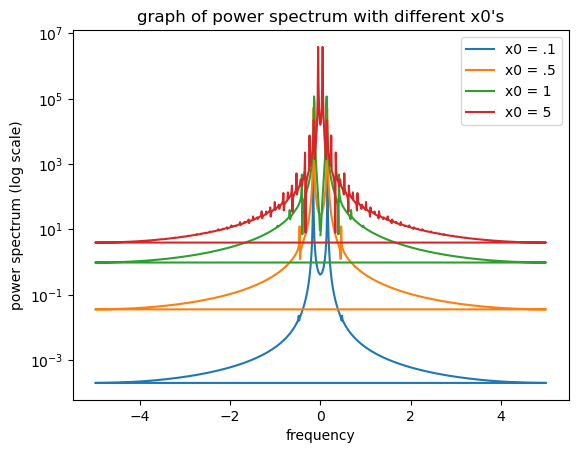

In [606]:
### want to plot freq versus fouriers^2

f_k, P_k = basic_fourier(discrete_lists[0], step_size)
f_k1, P_k1 = basic_fourier(discrete_lists[1], step_size)
f_k2, P_k2 = basic_fourier(discrete_lists[2], step_size)
f_k3, P_k3 = basic_fourier(discrete_lists[3], step_size)

power_spectrum = P_k ** 2
power_spectrum1 = P_k1 ** 2
power_spectrum2 = P_k2 ** 2
power_spectrum3 = P_k3 ** 2

plt.plot(f_k, np.abs(power_spectrum), label = "x0 = .1")
plt.plot(f_k1, np.abs(power_spectrum1), label = "x0 = .5")
plt.plot(f_k2, np.abs(power_spectrum2), label = "x0 = 1")
plt.plot(f_k3, np.abs(power_spectrum3), label = "x0 = 5")
plt.ylabel("power spectrum (log scale)")
plt.xlabel("frequency")
plt.title("graph of power spectrum with different x0's")
plt.yscale('log')  # Logarithmic scale on the y-axis
plt.legend()

As we can see in these results, after thinking about what the peaks should be, we see that because the amplitude of P_k changes for each of the initial positions, we get peaks that are much higher when p_o is higher. More specifically, we see that the peaks are given roughly by $\frac{AN}{2}$ where A is the amplitude of P_k. We can also see that the comparison to the SHO is less useful for greater x0 values because we notice the many tick marks as tjhe power spectrom goes to 0 (almost 0).

## Final Project Work

<font color = blue>
This week, you should submit your progress on your final project, in a separate Python notebook.  Your notebook should be organized the same way these assignments are (broken into sections, code correctly commented, and short discussions after each section.)  Keep in mind that depending on the topic of your project, I may have very little experience with it, which means your discussions need to be that much better!

At the end, include a brief discussion of what you *intended* to accomplish as compared with what you *did* accomplish, as well as a plan of what you intend to do in the following week.